### Project Title:

Modeling and prediction of energy consumption time series.

### Author: Luca D'Alessandro

### Objective:

In this project, I perform time series forcasting and modeling using and comparing two DL architecture: LSTM and LSTM + Multi Head Attention.
Moreover, I provide an example of feature engineering aimed to capture insideous patterns.
The first feature engineer attempt is made by detecting peaks in the train data and putting a 1 in a timestep if there is a peak. This leads to a 2D time series (energy consumtpion and the presence/absence of a peak).
The second attempt is made decomposing the signal in trend and seasonal part and concatenating them with the original time series, obtaing a 3D time series.
In the third trial, I only used seasonality and trend to forecast energy consumption values.

### Conclusions:

Without feature engineering, the forecasting performance of the two models is comparable, whilst my feature engineering approaches do not add anything to the perfromance of the model. In particular, using only seasonality and trend leads to an overall underestimation in the predictions.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vitthalmadane/energy-consumption-time-series-dataset")

print("Path to dataset files:", path)

100%|██████████| 34.8k/34.8k [00:00<00:00, 7.59MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vitthalmadane/energy-consumption-time-series-dataset/versions/3


In [2]:
!pip install --upgrade pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00


In [3]:
#!pip install numpy==1.26.4

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

In [5]:
os.listdir(path)

['KwhConsumptionBlower78_3.csv',
 'KwhConsumptionBlower78_1.csv',
 'KwhConsumptionBlower78_2.csv']

In [144]:
data1 = pd.read_csv(path + "/KwhConsumptionBlower78_1.csv",index_col=0)
data2 = pd.read_csv(path + "/KwhConsumptionBlower78_2.csv",index_col=0)
data3 = pd.read_csv(path + "/KwhConsumptionBlower78_3.csv",index_col=0)

In [145]:
data1.sort_values(by=["TxnDate","TxnTime"], inplace=True)
data2.sort_values(by=["TxnDate","TxnTime"], inplace=True)
data3.sort_values(by=["TxnDate","TxnTime"], inplace=True)

In [149]:
data1.drop_duplicates(inplace=True)
data2.drop_duplicates(inplace=True)
data3.drop_duplicates(inplace=True)

In [150]:
data = pd.concat([data1,data2,data3])
data["Time"] = data["TxnDate"] + " " + data["TxnTime"]
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace=True)
#data.index = pd.DatetimeIndex(data.index)
data = data[["Consumption"]]

<Axes: xlabel='Time'>

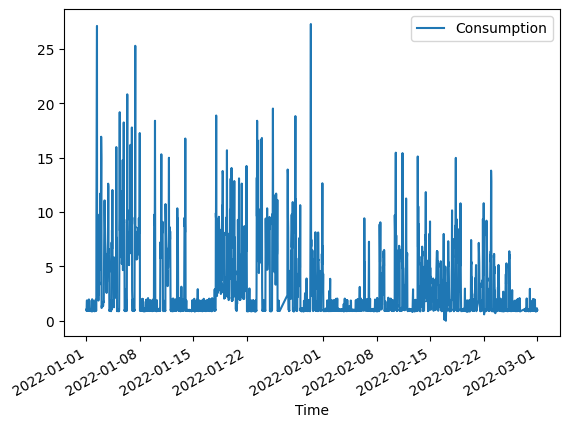

In [160]:
data.plot()

In [161]:
data.shape

(3582, 1)

## Define DL architectures

In [ ]:
# LSTM model

class LSTM_Model(tf.keras.Model):
  def __init__(self, units):
    super(LSTM_Model, self).__init__()
    self.units = units
    self.lstm = LSTM(units)
    self.dense = Dense(1)

  def call(self, inputs):
    x = self.lstm(inputs)
    x = self.dense(x)
    return x

#LSTM + Attention model

class LSTM_Attention_Model(tf.keras.Model):
  def __init__(self, units, heads, key_dim):
    super(LSTM_Attention_Model, self).__init__()
    self.units = units
    self.lstm = LSTM(units, return_sequences=True)
    self.attention = MultiHeadAttention(num_heads=heads, key_dim=key_dim)
    self.norm = LayerNormalization()
    self.dense = Dense(1)

  def call(self, inputs):
        x = self.lstm(inputs)

        # Create a causal mask (lower triangular to prevent future peeking)
        seq_len = tf.shape(x)[1]  # Get sequence length dynamically
        causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

        # Apply multi-head attention with masking
        x = self.attention(x, x, attention_mask=causal_mask)

        #Apply normalization
        x = self.norm(x)

        # Summarize the attended output (Alternative: Use GlobalAveragePooling)
        x = tf.reduce_mean(x, axis=1)

        return self.dense(x)

In [ ]:
def train_model(model, epochs, loss_fn, optimizer, train_dataset):
  print("Epoch: ",end="")
  losses = []
  for i in range(epochs):
    print(str(i+1)+"-", end="")
    batch_losses = []
    for batch_x, batch_y in train_dataset:
      with tf.GradientTape() as tape:
        predictions = model(batch_x)
        loss = loss_fn(batch_y, predictions)
      batch_losses.append(loss)

      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    mean_loss = np.mean(batch_losses)
    losses.append(mean_loss)
  return np.array(losses)

## Prepare data for feeding models:
the first half of the time series in used as training data, the second half as testing data. In this project, we try to forecast a value based on the three previous values.

### Attempt without feature engineer

In [162]:
N = len(data)
series_train = data.Consumption.values[:N//2]
series_test = data.Consumption.values[N//2:]

In [163]:
ws = 3 #window size
batch_size = 8

X_train = np.array([series_train[i:i+ws] for i in range(len(series_train)-ws)]).astype(np.float32)
y_train = np.array([series_train[i+ws] for i in range(len(series_train)-ws)]).astype(np.float32)

X_test = np.array([series_test[i:i+ws] for i in range(len(series_test)-ws)]).astype(np.float32)
y_test = np.array([series_test[i+ws] for i in range(len(series_test)-ws)]).astype(np.float32)

In [164]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1788, 3), (1788,), (1788, 3), (1788,))

In [166]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size, drop_remainder=True).shuffle(100)

In [169]:
hidden_units = 32

In [170]:
inputs = Input(shape=(ws, 1))
outputs = LSTM_Model(hidden_units)(inputs)
model1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model1.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model1.compile(optimizer=optimizer, loss=loss_fn)
model1.fit(train_dataset, epochs=20)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm__model_2 (LSTM_Model)      │ (None, 1)              │         4,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 19.7601
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.9130
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.0627
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3817
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6561
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5399
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7075
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4246
Epoch 9/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5087
Epoch 10/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8801
Epoch 11/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0697
Epoch 12/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3091
Epoch 13/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0478
Epoch 14/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0765
Epoch 15/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

In [171]:
heads = 4
key_dim = 16

inputs = Input(shape=(ws, 1))
outputs = LSTM_Attention_Model(hidden_units, heads, key_dim)(inputs)
model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model2.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss=loss_fn)
model2.fit(train_dataset, epochs=20)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm__attention__model_2        │ (None, 1)              │        12,865 │
│ (LSTM_Attention_Model)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,865 (50.25 KB)

 Trainable params: 12,865 (50.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.8499
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.4242
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6702
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.9675
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9134
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.1120
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7479
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.7455
Epoch 9/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0043
Epoch 10/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.7480
Epoch 11/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9674
Epoch 12/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1768
Epoch 13/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8387
Epoch 14/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.5973
Epoch 15/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

In [172]:
predictions_LSTM = model1.predict(X_test_sc)
predictions_LSTM_Attention = model2.predict(X_test_sc)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


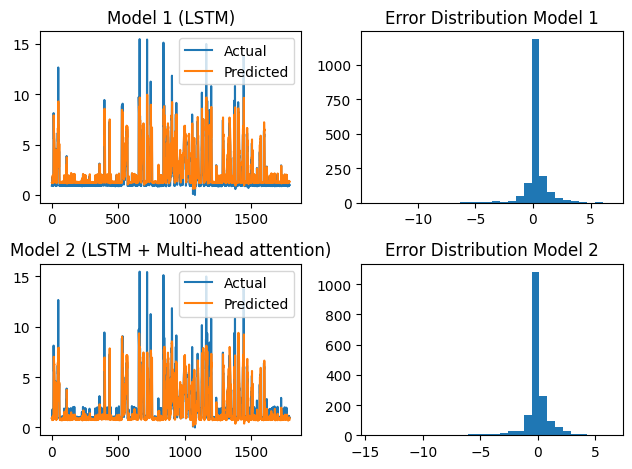

In [173]:
plt.subplot(2,2,1)
plt.plot(y_test, label="Actual")
plt.plot(predictions_LSTM, label="Predicted")
plt.title("Model 1 (LSTM)")
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test, label="Actual")
plt.plot(predictions_LSTM_Attention, label="Predicted")
plt.title("Model 2 (LSTM + Multi-head attention)")
plt.legend()

plt.subplot(2,2,2)
plt.hist(predictions_LSTM.flatten() - y_test, bins = 30)
plt.title("Error Distribution Model 1")

plt.subplot(2,2,4)
plt.hist(predictions_LSTM_Attention.flatten() - y_test, bins = 30)
plt.title("Error Distribution Model 2")

plt.tight_layout()
plt.show()

In [174]:
rmse_LSTM = np.sqrt(np.mean((y_test - predictions_LSTM)**2))
rmse_LSTM_Attention = np.sqrt(np.mean((y_test - predictions_LSTM_Attention)**2))
print("RMSE LSTM:", rmse_LSTM)
print("RMSE LSTM + Attention:", rmse_LSTM_Attention)

RMSE LSTM: 2.775569
RMSE LSTM + Attention: 2.826905


### Attempt with feature engineering: add peaks location

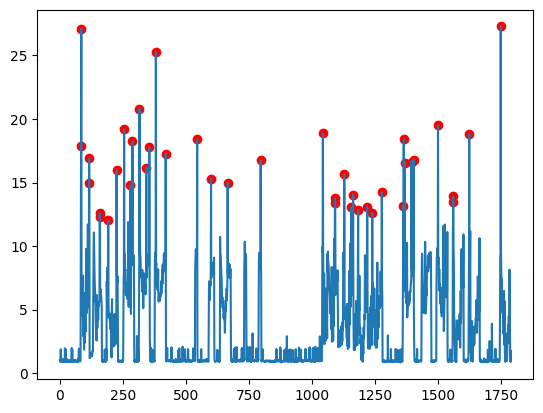

In [175]:
def find_peaks(window, threshold):
  window = np.array(window)
  res = np.zeros(len(window))
  res[window > threshold] = 1
  return res


#let's check visually how we could set the z-score threshold

peaks_train = find_peaks(series_train,12)
peak_times = np.where(peaks_train)[0]
plt.plot(series_train)
plt.scatter(peak_times,series_train[peak_times] , color='red')
plt.show()

In [176]:
peaks_train_windows = [find_peaks(window,12) for window in X_train_sc]
X_train_with_peaks = np.array([np.concatenate([window.reshape(1,-1),peaks.reshape(1,-1)]).T for window,peaks in zip(X_train_sc,peaks_train_windows)])

peaks_test_windows = [find_peaks(window,12) for window in X_test_sc]
X_test_with_peaks = np.array([np.concatenate([window.reshape(1,-1),peaks.reshape(1,-1)]).T for window,peaks in zip(X_test_sc,peaks_test_windows)])

In [177]:
X_train_with_peaks.shape, X_test_with_peaks.shape  #now time series have 2 features per time-step

((1788, 3, 2), (1788, 3, 2))

In [178]:
train_dataset_peaks = tf.data.Dataset.from_tensor_slices((X_train_with_peaks, y_train)).batch(batch_size, drop_remainder=True).shuffle(100)

In [179]:
inputs = Input(shape=(ws, 2))
outputs = LSTM_Model(hidden_units)(inputs)
model1_peaks = tf.keras.Model(inputs=inputs, outputs=outputs)

model1_peaks.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model1_peaks.compile(optimizer=optimizer, loss=loss_fn)
model1_peaks.fit(train_dataset_peaks, epochs=20)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm__model_3 (LSTM_Model)      │ (None, 1)              │         4,513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 19.7012
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0608
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3984
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.9414
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2413
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1909
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.9192
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0235
Epoch 9/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.1310
Epoch 10/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4194
Epoch 11/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7376
Epoch 12/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.7193
Epoch 13/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8104
Epoch 14/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6686
Epoch 15/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

In [287]:
heads = 4
key_dim = 16

inputs = Input(shape=(ws, 2))
outputs = LSTM_Attention_Model(hidden_units, heads, key_dim)(inputs)
model2_peaks = tf.keras.Model(inputs=inputs, outputs=outputs)

model2_peaks.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model2_peaks.compile(optimizer=optimizer, loss=loss_fn)
model2_peaks.fit(train_dataset_peaks, epochs=20)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 3, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm__attention__model_4        │ (None, 1)              │        12,993 │
│ (LSTM_Attention_Model)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,993 (50.75 KB)

 Trainable params: 12,993 (50.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.0416
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4632
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4348
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3706
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2004
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.4857
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4134
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.9122
Epoch 9/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2053
Epoch 10/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5594
Epoch 11/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.9425
Epoch 12/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.7487
Epoch 13/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.7724
Epoch 14/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.3534
Epoch 15/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - lo

In [288]:
predictions_LSTM_peaks = model1_peaks.predict(X_test_with_peaks)
predictions_LSTM_Attention_peaks = model2_peaks.predict(X_test_with_peaks)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


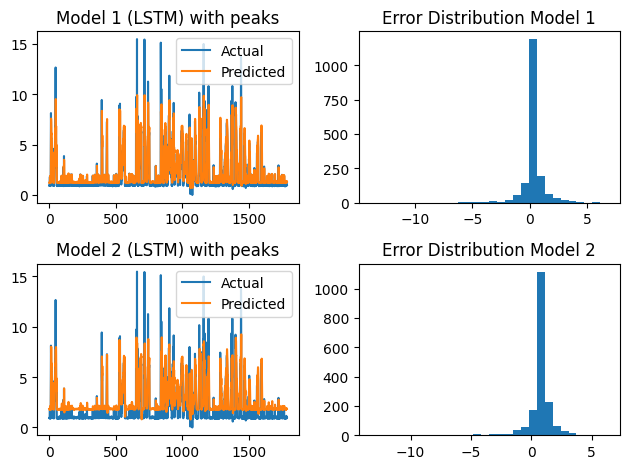

In [289]:
plt.figure(tight_layout=True)

plt.subplot(2,2,1)
plt.plot(y_test, label="Actual")
plt.plot(predictions_LSTM_peaks, label="Predicted")
plt.title("Model 1 (LSTM) with peaks")
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test, label="Actual")
plt.plot(predictions_LSTM_Attention_peaks, label="Predicted")
plt.title("Model 2 (LSTM) with peaks")
plt.legend()

plt.subplot(2,2,2)
plt.hist(predictions_LSTM_peaks.flatten() - y_test, bins = 30)
plt.title("Error Distribution Model 1")

plt.subplot(2,2,4)
plt.hist(predictions_LSTM_Attention_peaks.flatten() - y_test, bins = 30)
plt.title("Error Distribution Model 2")

plt.show()

In [297]:
rmse_LSTM_peaks = np.sqrt(np.mean((y_test - predictions_LSTM_peaks)**2))
rmse_LSTM_Attention_peaks = np.sqrt(np.mean((y_test - predictions_LSTM_Attention_peaks)**2))
print("RMSE LSTM:", rmse_LSTM_peaks)
print("RMSE LSTM + Attention:", rmse_LSTM_Attention_peaks)

RMSE LSTM: 2.758404
RMSE LSTM + Attention: 2.6906145


### Attempt with seasonality and trend extracted from the time series

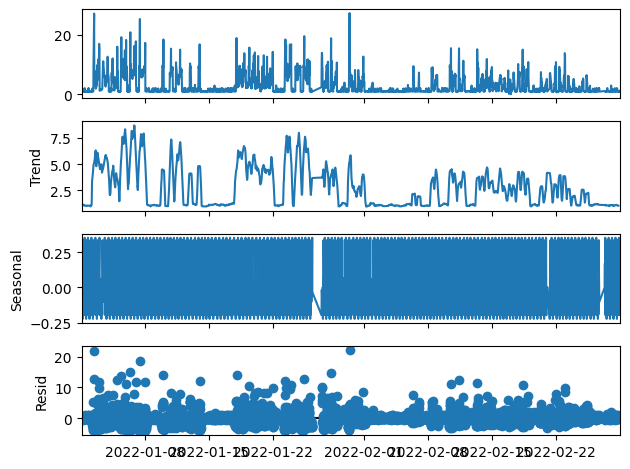

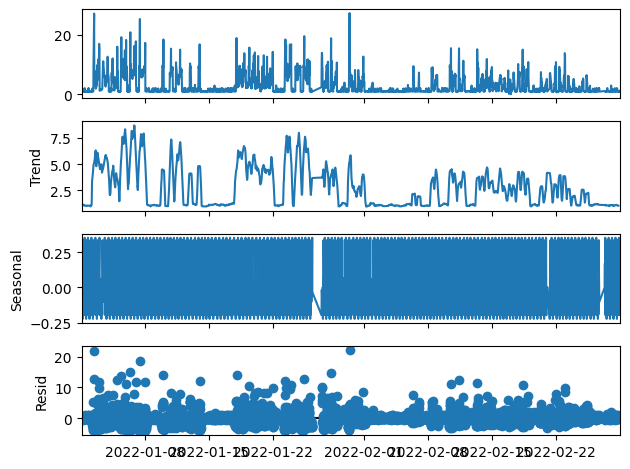

In [184]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(data,period=24)
decomposed.plot()

In [211]:
timesteps = np.unique(decomposed.trend.dropna().index)
data_trunc = data.loc[timesteps].values
trend = decomposed.trend.loc[timesteps].values
season = decomposed.seasonal.loc[timesteps].values

print(len(data_trunc))
print(len(trend))
print(len(season))

3558
3558
3558


In [224]:
data_with_dec = np.concat([data_trunc, trend.reshape(-1,1), season.reshape(-1,1)],axis=1)

In [232]:
N = data_with_dec.shape[0]
series_train_dec = data_with_dec[:N//2]
series_test_dec = data_with_dec[N//2:]

In [285]:
ws = 3
batch_size = 8

X_train_dec = np.array([series_train_dec[i:i+ws] for i in range(len(series_train_dec)-ws)]).astype(np.float32)
y_train_dec = [series_train_dec[:,0][ws+i] for i in range(len(series_train_dec)-ws)]

X_test_dec = np.array([series_test_dec[i:i+ws] for i in range(len(series_test_dec)-ws)]).astype(np.float32)
y_test_dec = [series_test_dec[:,0][ws+i] for i in range(len(series_test_dec)-ws)]

In [286]:
train_dataset_dec = tf.data.Dataset.from_tensor_slices((X_train_dec, y_train_dec)).batch(batch_size, drop_remainder=True).shuffle(100)

In [290]:
inputs = Input(shape=(ws, 3))
outputs = LSTM_Model(hidden_units)(inputs)
model1_dec = tf.keras.Model(inputs=inputs, outputs=outputs)

model1_dec.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model1_dec.compile(optimizer=optimizer, loss=loss_fn)
model1_dec.fit(train_dataset_dec, epochs=20)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 3, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm__model_4 (LSTM_Model)      │ (None, 1)              │         4,641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18.8036
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4503
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3017
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2364
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4131
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0749
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7611
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0309
Epoch 9/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.1014
Epoch 10/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1635
Epoch 11/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0817
Epoch 12/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9784
Epoch 13/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0560
Epoch 14/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7688
Epoch 15/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

In [291]:
heads = 4
key_dim = 16

inputs = Input(shape=(ws, 3))
outputs = LSTM_Attention_Model(hidden_units, heads, key_dim)(inputs)
model2_dec = tf.keras.Model(inputs=inputs, outputs=outputs)

model2_dec.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model2_dec.compile(optimizer=optimizer, loss=loss_fn)
model2_dec.fit(train_dataset_dec, epochs=20)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 3, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm__attention__model_5        │ (None, 1)              │        13,121 │
│ (LSTM_Attention_Model)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,121 (51.25 KB)

 Trainable params: 13,121 (51.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.6120
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4334
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9331
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 3.9642
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.1465
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8876
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3787
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5279
Epoch 9/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.1451
Epoch 10/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.4370
Epoch 11/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2222
Epoch 12/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.3705
Epoch 13/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0857
Epoch 14/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4405
Epoch 15/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l

In [293]:
predictions_LSTM_dec = model1_dec.predict(X_test_dec)
predictions_LSTM_Attention_dec = model2_dec.predict(X_test_dec)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


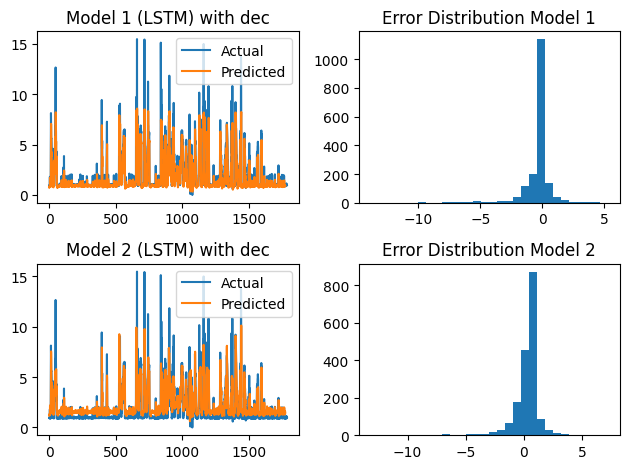

In [333]:
plt.figure(tight_layout=True)

plt.subplot(2,2,1)
plt.plot(y_test, label="Actual")
plt.plot(predictions_LSTM_dec, label="Predicted")
plt.title("Model 1 (LSTM) with dec")
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test, label="Actual")
plt.plot(predictions_LSTM_Attention_dec, label="Predicted")
plt.title("Model 2 (LSTM) with dec")
plt.legend()

plt.subplot(2,2,2)
plt.hist(predictions_LSTM_dec.flatten() - y_test_dec, bins = 30)
plt.title("Error Distribution Model 1")

plt.subplot(2,2,4)
plt.hist(predictions_LSTM_Attention_dec.flatten() - y_test_dec, bins = 30)
plt.title("Error Distribution Model 2")

plt.show()

In [334]:
rmse_LSTM_dec = np.sqrt(np.mean((y_test - predictions_LSTM_dec)**2))
rmse_LSTM_Attention_dec = np.sqrt(np.mean((y_test - predictions_LSTM_Attention_dec)**2))
print("RMSE LSTM:", rmse_LSTM_dec)
print("RMSE LSTM + Attention:", rmse_LSTM_Attention_dec)

RMSE LSTM: 2.5685306
RMSE LSTM + Attention: 2.4963994


### Using only seasonality and trend

In [308]:
data_with_dec2 = np.concat([trend.reshape(-1,1), season.reshape(-1,1)],axis=1)

In [309]:
N = data_with_dec2.shape[0]
data_trunc_train = data_trunc[:N//2]
data_trunc_test = data_trunc[N//2:]
series_train_dec2 = data_with_dec2[:N//2]
series_test_dec2 = data_with_dec2[N//2:]

In [310]:
ws = 3
batch_size = 8

X_train_dec2 = np.array([series_train_dec2[i:i+ws] for i in range(len(series_train_dec2)-ws)]).astype(np.float32)
y_train_dec2 = [data_trunc_train[:,0][ws+i] for i in range(len(data_trunc_train)-ws)]

X_test_dec2 = np.array([series_test_dec2[i:i+ws] for i in range(len(series_test_dec2)-ws)]).astype(np.float32)
y_test_dec2 = [data_trunc_test[:,0][ws+i] for i in range(len(data_trunc_test)-ws)]

In [311]:
train_dataset_dec2 = tf.data.Dataset.from_tensor_slices((X_train_dec2, y_train_dec2)).batch(batch_size, drop_remainder=True).shuffle(100)

In [312]:
inputs = Input(shape=(ws, 2))
outputs = LSTM_Model(hidden_units)(inputs)
model1_dec2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model1_dec2.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model1_dec2.compile(optimizer=optimizer, loss=loss_fn)
model1_dec2.fit(train_dataset_dec2, epochs=20)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 3, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm__model_7 (LSTM_Model)      │ (None, 1)              │         4,513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18.4623
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0930
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3238
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4677
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0474
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4574
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2205
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7355
Epoch 9/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1272
Epoch 10/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7211
Epoch 11/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1790
Epoch 12/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0510
Epoch 13/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8797
Epoch 14/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3585
Epoch 15/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

In [313]:
heads = 4
key_dim = 16

inputs = Input(shape=(ws, 2))
outputs = LSTM_Attention_Model(hidden_units, heads, key_dim)(inputs)
model2_dec2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model2_dec2.summary()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model2_dec2.compile(optimizer=optimizer, loss=loss_fn)
model2_dec2.fit(train_dataset_dec2, epochs=20)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 3, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm__attention__model_6        │ (None, 1)              │        12,993 │
│ (LSTM_Attention_Model)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,993 (50.75 KB)

 Trainable params: 12,993 (50.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 12.2190
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2880
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1817
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4619
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4785
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9375
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8677
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4245
Epoch 9/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2852
Epoch 10/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7256
Epoch 11/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3688
Epoch 12/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2703
Epoch 13/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9200
Epoch 14/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3790
Epoch 15/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - l

In [314]:
predictions_LSTM_dec2 = model1_dec2.predict(X_test_dec2)
predictions_LSTM_Attention_dec2 = model2_dec2.predict(X_test_dec2)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


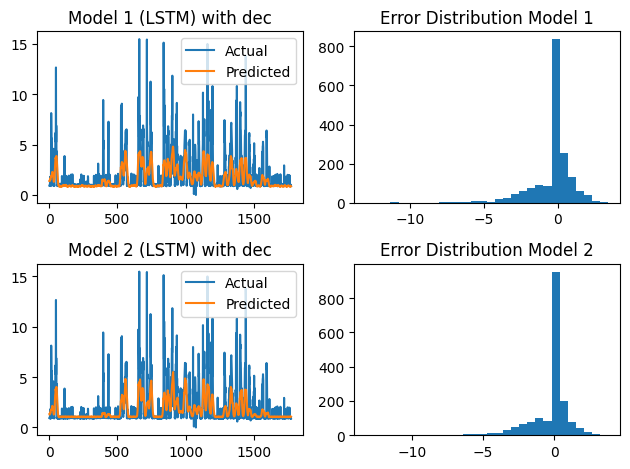

In [335]:
plt.figure(tight_layout=True)

plt.subplot(2,2,1)
plt.plot(y_test_dec2, label="Actual")
plt.plot(predictions_LSTM_dec2, label="Predicted")
plt.title("Model 1 (LSTM) with dec")
plt.legend()

plt.subplot(2,2,3)
plt.plot(y_test_dec2, label="Actual")
plt.plot(predictions_LSTM_Attention_dec2, label="Predicted")
plt.title("Model 2 (LSTM) with dec")
plt.legend()

plt.subplot(2,2,2)
plt.hist(predictions_LSTM_dec2.flatten() - y_test_dec2, bins = 30)
plt.title("Error Distribution Model 1")

plt.subplot(2,2,4)
plt.hist(predictions_LSTM_Attention_dec2.flatten() - y_test_dec2, bins = 30)
plt.title("Error Distribution Model 2")

plt.show()